Effect of noise
---------------

**Idea:** select 3 planes in the (x,z) plane. Perform dictionary learning on the 50% top part of the image and keep the 50% bottom part to test the reconstruction. Use up to 3000 elements on the dictionary.

**Methods:** 

- Take denoised images in $(x,z)$
- Play with the following parameters:
    - Compression ratio
    - PSF vs. dict model
    - Dimension of the input
    - SSIM vs. PSNR

In [239]:
## Various imports
%matplotlib inline
from libtiff import TIFF ## Now works with Python 3 !
import matplotlib.pyplot as plt
import numpy as np
import spams
import os, sys, time
import pandas
from skimage.measure import structural_similarity as ssim
sys.path.append('../../3_code/')
import cstools

p_psf = "../../5_outputs/psf_models/lattice_161114.npy" ## A PSF model
psf = np.load(p_psf)

p_out = "./2_noiseeffect/"
bp = "../../4_data/lattice-lightsheet/cell1_polii/"
l = os.listdir(bp)
l = [i for i in l if i.endswith('.tif')]

## 1. Create and display a denoised version of one plane

In [36]:
## Average a slice (e.g z=100)
allIm = []
for i in l:
    I=TIFF.open(os.path.join(bp,i))
    II = []
    for j in I.iter_images():
        II.append(j)
    I = np.zeros((II[0].shape[0], II[0].shape[1], len(II)))
    for (k,i) in enumerate(II):
        I[:,:,k] = i
    allIm.append(II)

denIm = np.zeros_like(allIm[0])
for i in range(len(allIm[0])):
    denIm[i,:,:]=np.sum([im[i] for im in allIm], axis=0)

Z = denIm.copy()
Z = Z-Z.mean()*0.9
Z[Z<0]=0

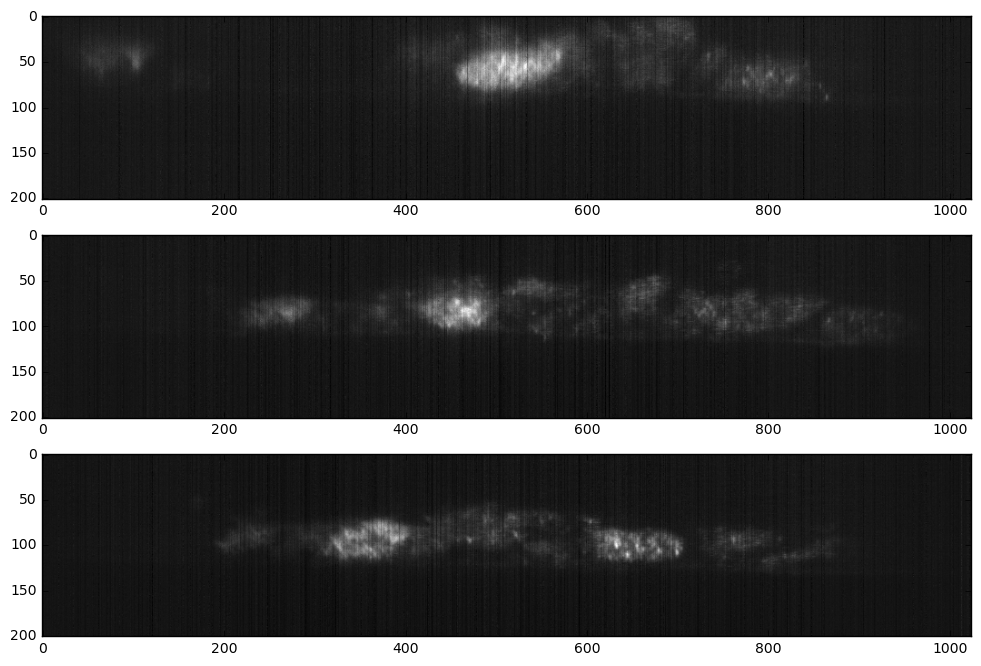

In [70]:
plt.figure(figsize=(18,8))
plt.subplot(311)
plt.imshow(Z[:,:,30], cmap='gray')
plt.subplot(312)
plt.imshow(Z[:,:,90], cmap='gray')
plt.subplot(313)
plt.imshow(Z[:,:,120], cmap='gray')

## 2. Estimate the empirical SNR and PSNR

In [161]:
noise_zone = Z[100:, :150, :]
signa_zone = (Z[40:75, 500:560, 30], Z[85:115, 625:700, 120])

signa = np.array([(i.sum(),i.size) for i in signa_zone]).sum(0)
signa = signa[0]/signa[1]
noise = noise_zone.var()**.5
print "Mean signal value: {},\nnoise std: {},\nSNR: {}".format(signa, noise, signa/noise)

Mean signal value: 715.167535213,
noise std: 23.1266217604,
SNR: 30.9239949795


## 3. Learn a dictionary from the data and build a PSF model

In [94]:
## Create learning and training set
tra = Z[:,512:,:]
tes = Z[:,:512,:]

## Perform dictionary learning on the last 50% of the pixels on the x axis.
tra_sub = tra[:,:,range(0,tra.shape[2],15)]
tra_sub = tra_sub[:,range(0,tra.shape[1],4),:]

patches = []
for i in range(tra_sub.shape[1]):
    for j in range(tra_sub.shape[2]):
        patches.append(tra_sub[:,i,j])
patches = np.vstack(patches)

paramTrain = {'K' : 2000, 'numThreads' : 30, 'iter' : 30}
X=np.asfortranarray(np.float_(patches).T)

print "Starting learning procedure, please be patient."
tic = time.time()
D = spams.nmf(X,**paramTrain)
toc = time.time() 
print "Dictionary learning performed in {} s".format(toc-tic) # Took 7 hrs for a dict. with 3000 atoms (and 4551 pixels/atom)

Starting learning procedure, please be patient.
Dictionary learning performed in 2288.57201695 s


In [115]:
## Alternative option: a (1D) PSF model
D_psf = np.zeros((tes.shape[0]+2*psf.shape[0], tes.shape[0]+psf.shape[0]))
Dproj = psf.mean(1)

for i in range(tes.shape[0]+psf.shape[0]):
    D_psf[i:(i+Dproj.shape[0]),i]=Dproj

D_psf = D_psf[Dproj.shape[0]:-Dproj.shape[0],:]

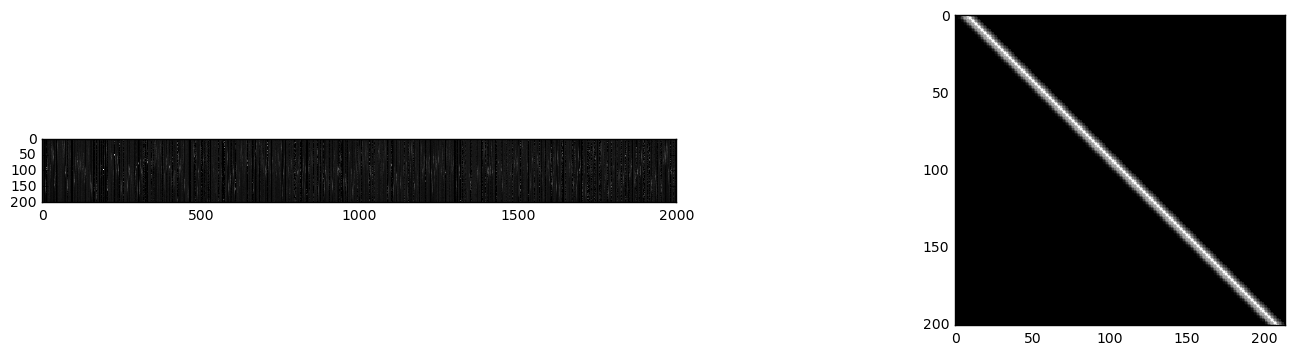

In [117]:
## Display and compare a dict model vs. a PSF model
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.imshow(D, cmap='gray', interpolation='none')
plt.subplot(122)
plt.imshow(D_psf, cmap='gray', interpolation='none')

## 4. Perform a set of reconstructions

In [249]:
## Stuffs to be sampled:
dicts = {"psf": D_psf,
         "nmf": D,
         "none": np.eye(D_psf.shape[0])}

sample = [("compression", range(2, 21, 2)),
          ("SNR", [0.2, 0.5, 1, 2, 5, 6, 8, 10]),
          ("ypos", range(0, tes.shape[2], 25)),
          ("dict", dicts.keys())
         ]

## Create an empty structure
results = {}
for c in sample[0][1]:
    for s in sample[1][1]:
        for z in sample[2][1]:
            for d in sample[3][1]:
                if not c in results:
                    results[c] = {}
                if not s in results[c]:
                    results[c][s] = {}
                if not z in results[c][s]:
                    results[c][s][z] = {}
                if d in results[c][s][z]:
                    raise Exception("Already defined")
                results[c][s][z][d] = 'na'
            
## Flatten it:
results_f = []
for c in sample[0][1]:
    for s in sample[1][1]:
        for z in sample[2][1]:
            for d in sample[3][1]:
                results_f.append({"compression": c, "SNR": s, "ypos": z, "dict": d})

parameters = pandas.DataFrame(results_f)
results = ['na']*parameters.shape[0] ## To be linked by id with the parameters table

## Define metrics (from http://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    # There is a bijection between PSNR and MSE: PSNR = 10*log(255*255/MSE) / log(10)
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err
# ssim defined in skimage.measure and used as ssim(imageA, imageB)

In [270]:
## Helper function that does the job
def the_real_worker(c, s, y, d, get_img=False):
    """This function does the following:
    1. Take an image at a given z position
    2. Apply a given amount of noise either in the image or in the transformed domain
    3. Compress the image
    4. Run the reconstruction, with a PSF or with a dictionary
    5. Compute metrics: SSIM and MSE"""
    signa ## This is the value of the signal (useful to compute SNR)
    nois = signa/float(s) ## The absolute noise value to be added
    
    di = dicts[d]
    im = tes[:,:,y]
    nm = int(im.shape[0]/c)
    no = []
    b=cstools.generate_fourier_basis(im.shape[0], nm+1, sample=False, oldmethod=True) ## Generate the basis

    for i in range(nm+1): ## Generate a series of noisy images
        n = np.random.normal(scale=nois, size=im.shape)+im
        n[n<0]=0
        no.append(n) 
    
    m = np.zeros((nm,im.shape[1])) ## make the measurements one by one
    for i in range(nm):
        mtmp = cstools.measure(no[i].T, b)
        m[i,:]=mtmp[:,i]
    if get_img:
        return m
    re = spiral2(m, b.dot(di)).T.dot(di.T).T ## Reconstruct
    
    res = {'reconstruction' : re,
           'original': im,
           'noisy': no[-1], # One noisy measurement
           'mse': mse(re, im),
           'mse2': mse(re, im)/im.mean(),
           'ssim': ssim(re, im),
           
           'compression': c,
           'snr': s,
           'ypos': y,
           'dict': d} ## compute metrics
    return res
    
## Additional helper functions
def spiral(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000, noisetype='poisson')
def spiral2(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000)

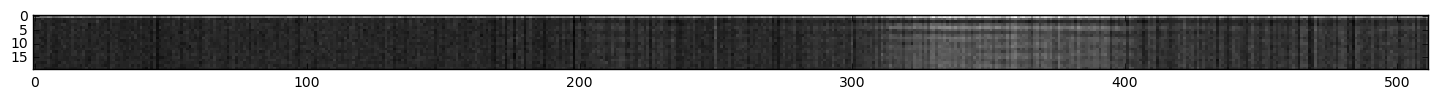

In [271]:
plt.figure(figsize=(18,4))
mmm = the_real_worker(10, 4, 125, "nmf", get_img=True) ## Building block!
plt.imshow(mmm, cmap='gray', interpolation='none')

plt.savefig("2.example_compressed.pdf")

In [ ]:
if not os.path.isdir(p_out):
    raise IOError("dir not found: {}".format(p_out))

for (i,j) in parameters.iterrows():
    s = j['SNR']
    c = j['compression']
    y = j['ypos']
    d = j['dict']
    fn = os.path.join(p_out, "{}_{}_{}_{}.npy".format(c,s,y,d)) ## Generate filename
    if os.path.exists(fn):  ## Check if not present
        print "{} exists, skipped".format(fn)
    else: ## Save a np object
        rr = the_real_worker(c, s, y, d)
        np.save(fn, rr)
    if i%100 == 0:
        print "{}/{}".format(i, parameters.shape[0])
        
parameters_save = parameters.copy()
filenames = ["{}_{}_{}_{}.npy".format(j['compression'],j['SNR'],j['ypos'],j['dict']) for (i,j) in parameters.iterrows()]
parameters_save["filename"] = filenames
np.save(os.path.join(p_out, "params.npy"), parameters_save)

0/2640


SSIM: 0.436904202364, MSE: 1253.59517699


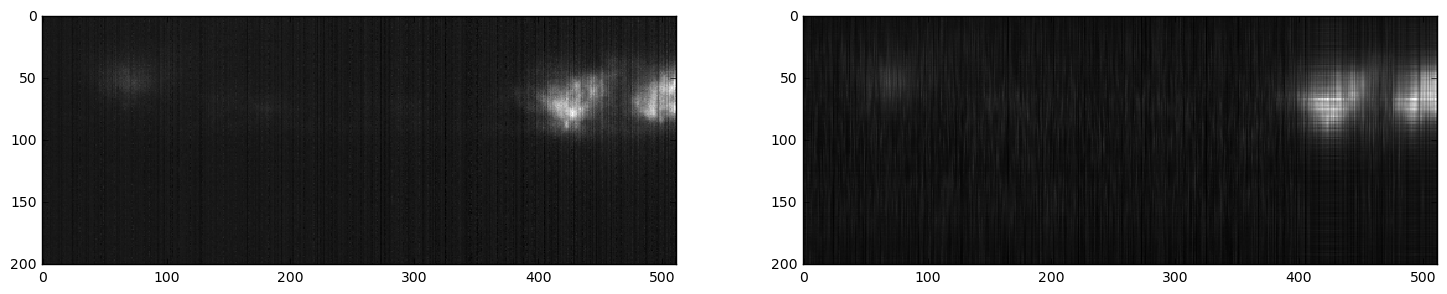

In [232]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.imshow(rr['original'], cmap='gray', interpolation='none')
plt.subplot(122)
plt.imshow(rr['reconstruction'], cmap='gray', interpolation='none')

print "SSIM: {}, MSE: {}".format(rr["ssim"], rr["mse"])

In [272]:
Z.shape

(201, 1024, 256)